# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

## Read the Starbucks challenge data
- portfolio.json - Contains offer identifiers and offer meta data (e.g. duration, type, etc.)
- profile.json - Customer demographics data
- transcript.json - Describes customer transactions and when offers are received, viewed, and completed.

In [47]:
import pandas as pd
import numpy as np
import math
import json
import calendar
#% matplotlib inline
import matplotlib.pyplot as plt

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [48]:
portfolio['channels'] = [','.join(map(str, l)) for l in portfolio['channels']]

In [49]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"email,mobile,social",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"web,email,mobile,social",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"web,email,mobile",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"web,email,mobile",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"web,email",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"web,email,mobile,social",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"web,email,mobile,social",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"email,mobile,social",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"web,email,mobile,social",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"web,email,mobile",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [50]:
web = [1 if 'web' in score
else 0
for score in portfolio['channels']]
email = [1 if 'email' in score
else 0
for score in portfolio['channels']]
mobile = [1 if 'mobile' in score
else 0
for score in portfolio['channels']]
social = [1 if 'social' in score
else 0
for score in portfolio['channels']]

portfolio['web'] = web
portfolio['email'] = email
portfolio['mobile'] = mobile
portfolio['social'] = social

In [51]:
portfolio

,channels,difficulty,duration,id,offer_type,reward,web,email,mobile,social
0,"email,mobile,social",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,0,1,1,1
1,"web,email,mobile,social",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,"web,email,mobile",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,1,0
3,"web,email,mobile",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,1,0
4,"web,email",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,1,0,0
5,"web,email,mobile,social",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1
6,"web,email,mobile,social",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1
7,"email,mobile,social",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,0,1,1,1
8,"web,email,mobile,social",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1
9,"web,email,mobile",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,1,0


In [52]:
portfolio = portfolio.drop(columns = ['channels'])

In [53]:
portfolio

,difficulty,duration,id,offer_type,reward,web,email,mobile,social
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,0,1,1,1
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,1,0
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,1,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,1,0,0
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1
7,0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,0,1,1,1
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1
9,10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,1,0


In [54]:
offer_type = pd.get_dummies(portfolio['offer_type'])

portfolio = pd.concat([portfolio, offer_type], axis=1, sort=False)

portfolio = portfolio.drop(columns = ['offer_type'])

In [55]:
portfolio

,difficulty,duration,id,reward,web,email,mobile,social,bogo,discount,informational
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,0,1,1,1,1,0,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,1,1,1,1,0,0
2,0,4,3f207df678b143eea3cee63160fa8bed,0,1,1,1,0,0,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,1,1,0,1,0,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,1,1,0,0,0,1,0
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,3,1,1,1,1,0,1,0
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,2,1,1,1,1,0,1,0
7,0,3,5a8bc65990b245e5a138643cd4eb9837,0,0,1,1,1,0,0,1
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,5,1,1,1,1,1,0,0
9,10,7,2906b810c7d4411798c6938adc9daaa5,2,1,1,1,0,0,1,0


In [56]:
profile

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0
9,118,20161122,None,8974fc5686fe429db53ddde067b88302,NaN


In [57]:
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [58]:
profile.age[profile['age']>101].describe()

count    2175.0
mean      118.0
std         0.0
min       118.0
25%       118.0
50%       118.0
75%       118.0
max       118.0
Name: age, dtype: float64

In [59]:
profile['age'] = profile['age'].apply(lambda x: np.nan if x == 118 else x)
profile.isnull().sum()

age                 2175
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [60]:
profile.dropna(inplace=True)
profile.isnull().sum()

age                 0
became_member_on    0
gender              0
id                  0
income              0
dtype: int64

In [61]:
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')

In [62]:
#dropping column 'became_member_on' from the profile table.
year = [dt.year for dt in profile['became_member_on']]
month = [dt.month for dt in profile['became_member_on']]
day = [calendar.day_name[dt.weekday()] for dt in profile['became_member_on']]

profile['membership_year'] = year
profile['membership_month'] = month
profile['membership_day'] = day

profile = profile.drop(columns = ['became_member_on'])
profile

,age,gender,id,income,membership_year,membership_month,membership_day
1,55.0,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,7,Saturday
3,75.0,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,5,Tuesday
5,68.0,M,e2127556f4f64592b11af22de27a7932,70000.0,2018,4,Thursday
8,65.0,M,389bc3fa690240e798340f5a15918d5c,53000.0,2018,2,Friday
12,58.0,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017,11,Saturday
13,61.0,F,aa4862eba776480b8bb9c68455b8c2e1,57000.0,2017,9,Monday
14,26.0,M,e12aeaf2d47d42479ea1c4ac3d8286c6,46000.0,2014,2,Thursday
15,62.0,F,31dda685af34476cad5bc968bdb01c53,71000.0,2016,2,Thursday
16,49.0,M,62cf5e10845442329191fc246e7bcea3,52000.0,2014,11,Thursday
18,57.0,M,6445de3b47274c759400cd68131d91b4,42000.0,2017,12,Sunday


In [63]:
transcript

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
6,offer received,c4863c7985cf408faee930f111475da3,0,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
9,offer received,31dda685af34476cad5bc968bdb01c53,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}


In [64]:
transcript = transcript[transcript['value'].apply(lambda x: True if ('offer id' in x) or ('offer_id' in x) else False)]

In [65]:
transcript['offer_id'] = transcript['value'].apply(lambda x: x['offer id'] if ('offer id' in x) else x['offer_id'])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [66]:
transcript

,event,person,time,value,offer_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0
5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},f19421c1d4aa40978ebb69ca19b0e20d
6,offer received,c4863c7985cf408faee930f111475da3,0,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},2298d6c36e964ae4a3e7e9706d1fb8c2
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'},3f207df678b143eea3cee63160fa8bed
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7
9,offer received,31dda685af34476cad5bc968bdb01c53,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7


In [67]:
#dropping column 'value' from the transcript table.
transcript = transcript.drop(columns = ['value'])

In [68]:
transcript

,event,person,time,offer_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0
5,offer received,389bc3fa690240e798340f5a15918d5c,0,f19421c1d4aa40978ebb69ca19b0e20d
6,offer received,c4863c7985cf408faee930f111475da3,0,2298d6c36e964ae4a3e7e9706d1fb8c2
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,3f207df678b143eea3cee63160fa8bed
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7
9,offer received,31dda685af34476cad5bc968bdb01c53,0,0b1e1539f2cc45b7b9fa7c272da2e1d7


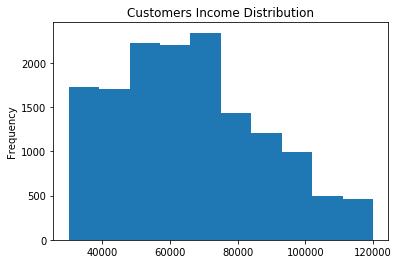

In [69]:
#Histogram to depict distributon of customer income.
profile['income'].plot.hist()
plt.title('Customers Income Distribution')
plt.show()

In [70]:
profile['age'].value_counts().head()

58.0    408
53.0    372
51.0    363
59.0    359
54.0    359
Name: age, dtype: int64

In [71]:
profile['age'][profile['gender'] == 'M']

5        68.0
8        65.0
12       58.0
14       26.0
16       49.0
18       57.0
21       64.0
24       42.0
29       59.0
30       67.0
32       22.0
34       40.0
37       56.0
40       75.0
42       45.0
43       61.0
48       39.0
55       42.0
59       45.0
60       29.0
61       44.0
62       63.0
63       36.0
65       68.0
66       75.0
67       67.0
68       77.0
69       76.0
70       57.0
78       30.0
         ... 
16926    55.0
16929    30.0
16933    85.0
16935    56.0
16937    51.0
16939    57.0
16941    19.0
16943    37.0
16944    45.0
16945    24.0
16952    64.0
16955    56.0
16956    58.0
16957    21.0
16959    66.0
16960    25.0
16964    52.0
16965    52.0
16966    54.0
16967    54.0
16968    74.0
16970    67.0
16973    30.0
16981    84.0
16985    26.0
16987    57.0
16988    64.0
16993    60.0
16996    61.0
16997    49.0
Name: age, Length: 8484, dtype: float64

In [72]:
#verifying distribution of customers age - 'Males'
profile['age'][profile['gender'] == 'M'].describe()

count    8484.000000
mean       52.116690
std        17.413894
min        18.000000
25%        39.000000
50%        53.000000
75%        65.000000
max       100.000000
Name: age, dtype: float64

In [73]:
#verifying distribution of customers age - 'Female'
profile['age'][profile['gender'] == 'F'].describe()

count    6129.000000
mean       57.544950
std        16.883315
min        18.000000
25%        48.000000
50%        58.000000
75%        69.000000
max       101.000000
Name: age, dtype: float64

In [74]:
#verifying distribution of customers age - 'Other'
profile['age'][profile['gender'] == 'O'].describe()

count    212.000000
mean      54.400943
std       16.244710
min       20.000000
25%       43.000000
50%       55.000000
75%       66.000000
max      100.000000
Name: age, dtype: float64

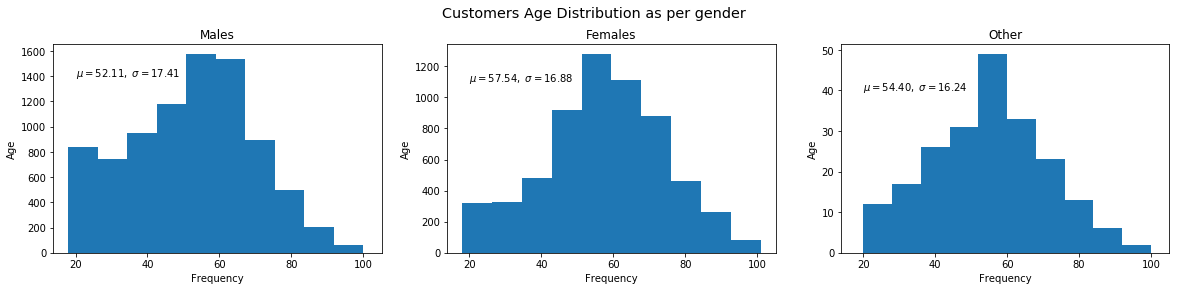

In [75]:
#plotting histograms as subplots to represent Customers Age distribution as per gender.
fig, ax = plt.subplots(1, 3, sharex=True, figsize=(20,4))
plt.sca(ax[0])
plt.hist(x=profile['age'][profile['gender'] == 'M'])
plt.xlabel('Frequency')
plt.ylabel('Age')
plt.title('Males')
plt.text(20, 1400, r'$\mu=52.11,\ \sigma=17.41$')
plt.sca(ax[1])
plt.hist(x=profile['age'][profile['gender'] == 'F'])
plt.xlabel('Frequency')
plt.ylabel('Age')
plt.title('Females')
plt.text(20, 1100, r'$\mu=57.54,\ \sigma=16.88$')
plt.sca(ax[2])
plt.hist(x=profile['age'][profile['gender'] == 'O'])
plt.xlabel('Frequency')
plt.ylabel('Age')
plt.title('Other')
plt.text(20, 40, r'$\mu=54.40,\ \sigma=16.24$')
fig.suptitle('Customers Age Distribution as per gender', fontsize='x-large')
fig.subplots_adjust(top=0.85)

The Customer Age distribution as per histogram yields results as 'Females' being amongst the highest number of customers followed by Other gender and 'Males' being the lowest in terms of customers.

In [76]:
profile['income'][profile['gender'] == 'M'].describe()

count      8484.000000
mean      61194.601603
std       20069.517615
min       30000.000000
25%       45000.000000
50%       59000.000000
75%       73000.000000
max      120000.000000
Name: income, dtype: float64

In [77]:
profile['income'][profile['gender'] == 'F'].describe()

count      6129.000000
mean      71306.412139
std       22338.353773
min       30000.000000
25%       54000.000000
50%       71000.000000
75%       88000.000000
max      120000.000000
Name: income, dtype: float64

In [78]:
profile['income'][profile['gender'] == 'O'].describe()

count       212.000000
mean      63287.735849
std       18938.594726
min       30000.000000
25%       51000.000000
50%       62000.000000
75%       79250.000000
max      100000.000000
Name: income, dtype: float64

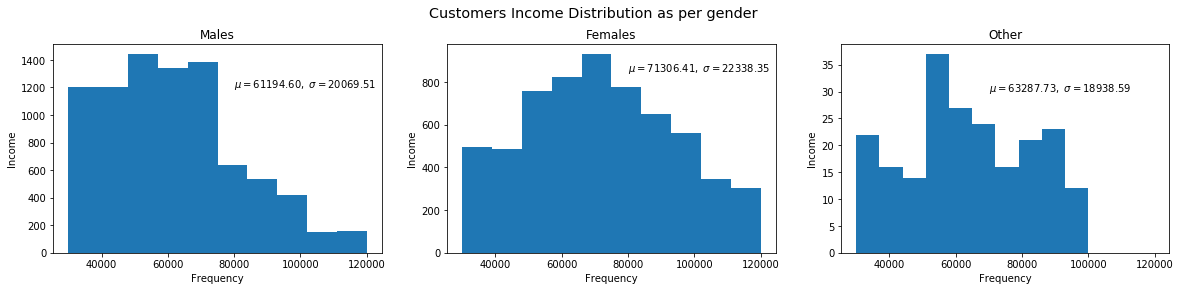

In [79]:
#Customer Income distribution as per gender depicted by histogram.
fig, ax = plt.subplots(1, 3, sharex=True, figsize=(20,4))
plt.sca(ax[0])
plt.hist(x=profile['income'][profile['gender'] == 'M'])
plt.xlabel('Frequency')
plt.ylabel('Income')
plt.title('Males')
plt.text(80000, 1200, r'$\mu=61194.60,\ \sigma=20069.51$')
plt.sca(ax[1])
plt.hist(x=profile['income'][profile['gender'] == 'F'])
plt.xlabel('Frequency')
plt.ylabel('Income')
plt.title('Females')
plt.text(80000, 850, r'$\mu=71306.41,\ \sigma=22338.35$')
plt.sca(ax[2])
plt.hist(x=profile['income'][profile['gender'] == 'O'])
plt.xlabel('Frequency')
plt.ylabel('Income')
plt.title('Other')
plt.text(70000, 30, r'$\mu=63287.73,\ \sigma=18938.59$')
fig.suptitle('Customers Income Distribution as per gender', fontsize='x-large')
fig.subplots_adjust(top=0.85)

As per the histogram results, Females have the highest income as per Customer distribution followed by Other gender categories and the lowest being 'Males'

In [80]:
profile.membership_year.head()


1     2017
3     2017
5     2018
8     2018
12    2017
Name: membership_year, dtype: int64

In [81]:
profile.membership_month.head()

1      7
3      5
5      4
8      2
12    11
Name: membership_month, dtype: int64

In [82]:
profile.membership_day.head()

1     Saturday
3      Tuesday
5     Thursday
8       Friday
12    Saturday
Name: membership_day, dtype: object

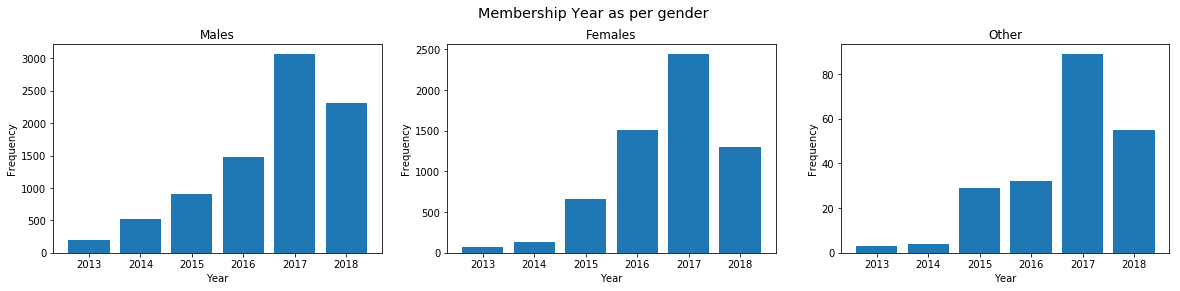

In [83]:
#Count of members who joined as per membership year.
fig, ax = plt.subplots(1, 3, sharex=True, figsize=(20,4))
plt.sca(ax[0])
plt.bar(x=pd.value_counts(profile['membership_year'][profile['gender'] == 'M']).index, height=pd.value_counts(profile['membership_year'][profile['gender'] == 'M']))
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Males')
plt.sca(ax[1])
plt.bar(x=pd.value_counts(profile['membership_year'][profile['gender'] == 'F']).index, height=pd.value_counts(profile['membership_year'][profile['gender'] == 'F']))
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Females')
plt.sca(ax[2])
plt.bar(x=pd.value_counts(profile['membership_year'][profile['gender'] == 'O']).index, height=pd.value_counts(profile['membership_year'][profile['gender'] == 'O']))
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Other')
fig.suptitle('Membership Year as per gender', fontsize='x-large')
fig.subplots_adjust(top=0.85)

As per the bar plots, 2017 has been the highest number of memberships in all three gender categories and 2013 have had the lowest number of memberships.

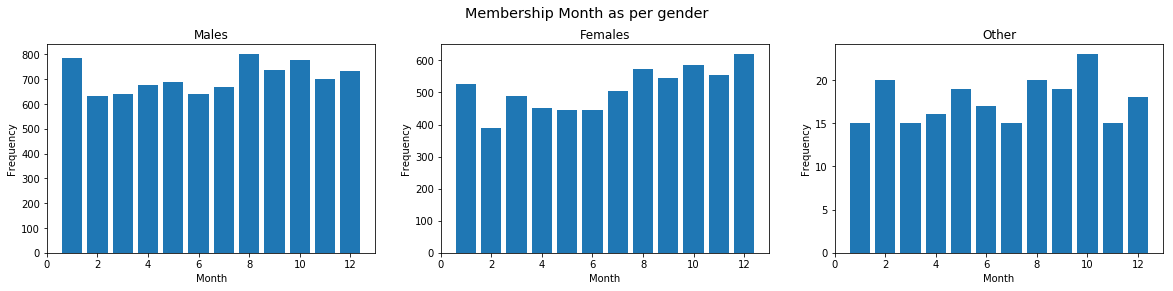

In [84]:
#Count of members who joined as per membership month.
fig, ax = plt.subplots(1, 3, sharex=True, figsize=(20,4))
plt.sca(ax[0])
plt.bar(x=pd.value_counts(profile['membership_month'][profile['gender'] == 'M']).index, height=pd.value_counts(profile['membership_month'][profile['gender'] == 'M']))
plt.xlabel('Month')
plt.ylabel('Frequency')
plt.title('Males')
plt.sca(ax[1])
plt.bar(x=pd.value_counts(profile['membership_month'][profile['gender'] == 'F']).index, height=pd.value_counts(profile['membership_month'][profile['gender'] == 'F']))
plt.xlabel('Month')
plt.ylabel('Frequency')
plt.title('Females')
plt.sca(ax[2])
plt.bar(x=pd.value_counts(profile['membership_month'][profile['gender'] == 'O']).index, height=pd.value_counts(profile['membership_month'][profile['gender'] == 'O']))
plt.xlabel('Month')
plt.ylabel('Frequency')
plt.title('Other')
fig.suptitle('Membership Month as per gender', fontsize='x-large')
fig.subplots_adjust(top=0.85)

As per bar plots, Males have had the highest number of memberships on Saturdays and lowest on Fridays, Femals have had the highest number of memberships on Sunday and Tuesdays, lowest on Saturdays and Wednesdays, Other gender category has had the highest memberships on Thursdays and lowest on Saturdays.

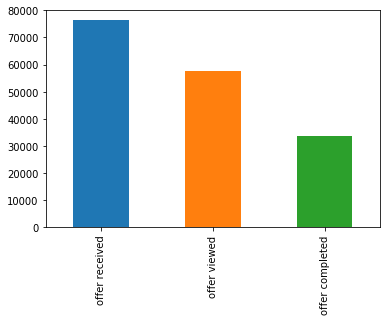

In [85]:
pd.value_counts(transcript['event']).plot.bar()

In [86]:
transcript['time'][transcript['event'] == 'offer received'].describe()

count    76277.000000
mean       332.579519
std        196.489548
min          0.000000
25%        168.000000
50%        408.000000
75%        504.000000
max        576.000000
Name: time, dtype: float64

In [87]:
transcript['time'][transcript['event'] == 'offer viewed'].describe()

count    57725.000000
mean       354.290515
std        199.317684
min          0.000000
25%        180.000000
50%        408.000000
75%        516.000000
max        714.000000
Name: time, dtype: float64

In [88]:
transcript['time'][transcript['event'] == 'offer completed'].describe()

count    33579.000000
mean       401.052801
std        192.352614
min          0.000000
25%        240.000000
50%        432.000000
75%        564.000000
max        714.000000
Name: time, dtype: float64

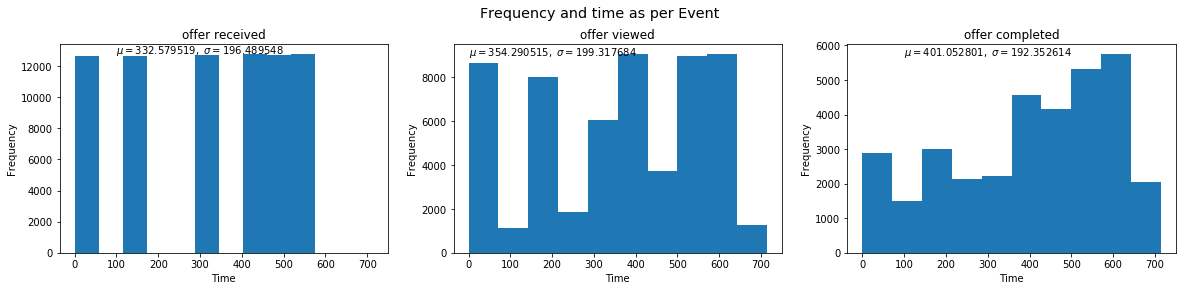

In [89]:
#Frequency and time histogram plots as per event
fig, ax = plt.subplots(1, 3, sharex=True, figsize=(20,4))
plt.sca(ax[0])
plt.hist(x=transcript['time'][transcript['event'] == 'offer received'])
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('offer received')
plt.text(100, 12800, r'$\mu=332.579519,\ \sigma=196.489548$')
plt.sca(ax[1])
plt.hist(x=transcript['time'][transcript['event'] == 'offer viewed'])
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('offer viewed')
plt.text(0, 9000, r'$\mu=354.290515,\ \sigma=199.317684$')
plt.sca(ax[2])
plt.hist(x=transcript['time'][transcript['event'] == 'offer completed'])
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('offer completed')
plt.text(100, 5700, r'$\mu=401.052801,\ \sigma=192.352614$')
fig.suptitle('Frequency and time as per Event', fontsize='x-large')
fig.subplots_adjust(top=0.85)

As per histograms, there are highest number of offers completed followed by offers viewed and offers received.

In [90]:
result = pd.merge(portfolio, transcript,
                 left_on = 'id',
                 right_on = 'offer_id',
                how = 'inner')

In [91]:
result.rename(columns={'id':'offer_id_t','offer_id':'offer_id_pt','person':'mem_id_t'},inplace=True)
result.head()

,difficulty,duration,offer_id_t,reward,web,email,mobile,social,bogo,discount,informational,event,mem_id_t,time,offer_id_pt
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,0,1,1,1,1,0,0,offer received,4b0da7e80e5945209a1fdddfe813dbe0,0,ae264e3637204a6fb9bb56bc8210ddfd
1,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,0,1,1,1,1,0,0,offer received,1e9420836d554513ab90eba98552d0a9,0,ae264e3637204a6fb9bb56bc8210ddfd
2,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,0,1,1,1,1,0,0,offer received,02c083884c7d45b39cc68e1314fec56c,0,ae264e3637204a6fb9bb56bc8210ddfd
3,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,0,1,1,1,1,0,0,offer received,676506bad68e4161b9bbaffeb039626b,0,ae264e3637204a6fb9bb56bc8210ddfd
4,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,0,1,1,1,1,0,0,offer received,fe8264108d5b4f198453bbb1fa7ca6c9,0,ae264e3637204a6fb9bb56bc8210ddfd


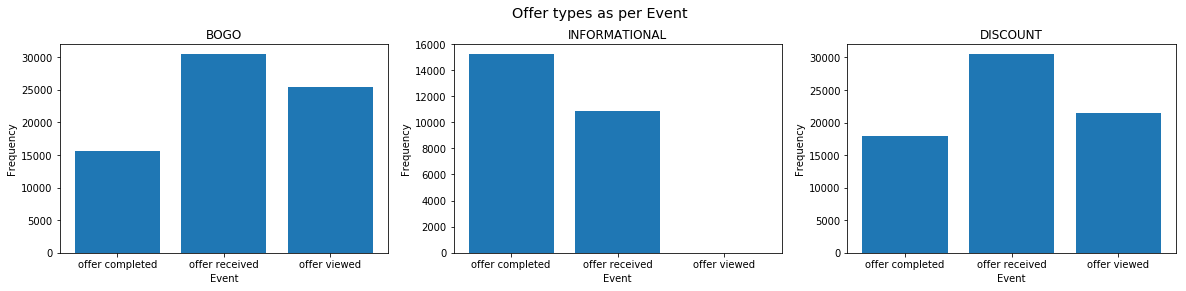

In [92]:
#Bar plots for Offer types as per event.
fig, ax = plt.subplots(1, 3, sharex=True, figsize=(20,4))
plt.sca(ax[0])
plt.bar(x=pd.value_counts(result['event'][result['bogo'] == 1]).index, height=pd.value_counts(result['event'][result['bogo'] == 1]))
plt.xlabel('Event')
plt.ylabel('Frequency')
plt.title('BOGO')
plt.sca(ax[1])
plt.bar(x=pd.value_counts(result['event'][result['informational'] == 1]).index, height=pd.value_counts(result['event'][result['informational'] == 1]))
plt.xlabel('Event')
plt.ylabel('Frequency')
plt.title('INFORMATIONAL')
plt.sca(ax[2])
plt.bar(x=pd.value_counts(result['event'][result['discount'] == 1]).index, height=pd.value_counts(result['event'][result['discount'] == 1]))
plt.xlabel('Event')
plt.ylabel('Frequency')
plt.title('DISCOUNT')
fig.suptitle('Offer types as per Event', fontsize='x-large')
fig.subplots_adjust(top=0.85)

As per the above Bar plots, Bogo and Discount have the highest number of offers received and Informational has the highest number of offers completed followed by Offer viewed in Bogo and Discount and offer received in Informational and the lowest in Bogo and Discount for offers completed. 
This just goes to prove that for Informational portfolio type, it isn't necessary that a member completes the transaction for offer viewed in for the transaction to be successfully completed.

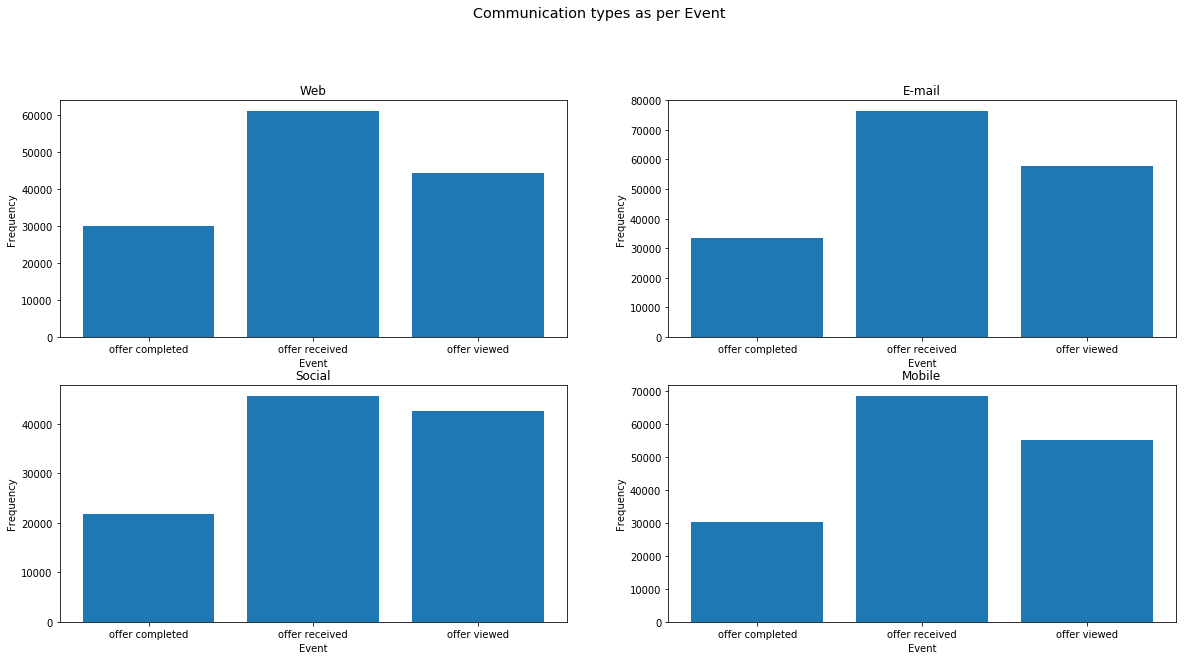

In [93]:
#Bar plots for communication types as per event
fig, ax = plt.subplots(2, 2, figsize=(20,10))
plt.sca(ax[0,0])
plt.bar(x=pd.value_counts(result['event'][result['web'] == 1]).index, height=pd.value_counts(result['event'][result['web'] == 1]))
plt.xlabel('Event')
plt.ylabel('Frequency')
plt.title('Web')
plt.sca(ax[0,1])
plt.bar(x=pd.value_counts(result['event'][result['email'] == 1]).index, height=pd.value_counts(result['event'][result['email'] == 1]))
plt.xlabel('Event')
plt.ylabel('Frequency')
plt.title('E-mail')
plt.sca(ax[1,0])
plt.bar(x=pd.value_counts(result['event'][result['social'] == 1]).index, height=pd.value_counts(result['event'][result['social'] == 1]))
plt.xlabel('Event')
plt.ylabel('Frequency')
plt.title('Social')
plt.sca(ax[1,1])
plt.bar(x=pd.value_counts(result['event'][result['mobile'] == 1]).index, height=pd.value_counts(result['event'][result['mobile'] == 1]))
plt.xlabel('Event')
plt.ylabel('Frequency')
plt.title('Mobile')
fig.suptitle('Communication types as per Event', fontsize='x-large')
fig.subplots_adjust(top=0.85)

Portfolios with Web, Mobile, E-mail and Social have the highest numbers of Offers received with moderate number of offers viewed. Social has the highest number of offers viewed followed by Web being the lowest in terms of completed offers.

In [94]:
result = pd.merge(result, profile,
                 left_on = 'mem_id_t',
                 right_on = 'id',
                how = 'inner')

In [95]:
result = result.drop(columns = ['id','offer_id_pt'])
result

,difficulty,duration,offer_id_t,reward,web,email,mobile,social,bogo,discount,informational,event,mem_id_t,time,age,gender,income,membership_year,membership_month,membership_day
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,0,1,1,1,1,0,0,offer received,4b0da7e80e5945209a1fdddfe813dbe0,0,64.0,M,100000.0,2017,9,Saturday
1,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,0,1,1,1,1,0,0,offer viewed,4b0da7e80e5945209a1fdddfe813dbe0,102,64.0,M,100000.0,2017,9,Saturday
2,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,0,1,1,1,1,0,0,offer received,4b0da7e80e5945209a1fdddfe813dbe0,504,64.0,M,100000.0,2017,9,Saturday
3,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,0,1,1,1,1,0,0,offer viewed,4b0da7e80e5945209a1fdddfe813dbe0,510,64.0,M,100000.0,2017,9,Saturday
4,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,0,1,1,1,1,0,0,offer completed,4b0da7e80e5945209a1fdddfe813dbe0,510,64.0,M,100000.0,2017,9,Saturday
5,0,4,3f207df678b143eea3cee63160fa8bed,0,1,1,1,0,0,0,1,offer received,4b0da7e80e5945209a1fdddfe813dbe0,408,64.0,M,100000.0,2017,9,Saturday
6,0,4,3f207df678b143eea3cee63160fa8bed,0,1,1,1,0,0,0,1,offer viewed,4b0da7e80e5945209a1fdddfe813dbe0,468,64.0,M,100000.0,2017,9,Saturday
7,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,1,1,0,0,0,1,0,offer received,4b0da7e80e5945209a1fdddfe813dbe0,168,64.0,M,100000.0,2017,9,Saturday
8,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,1,1,0,0,0,1,0,offer viewed,4b0da7e80e5945209a1fdddfe813dbe0,174,64.0,M,100000.0,2017,9,Saturday
9,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,1,1,0,0,0,1,0,offer completed,4b0da7e80e5945209a1fdddfe813dbe0,180,64.0,M,100000.0,2017,9,Saturday


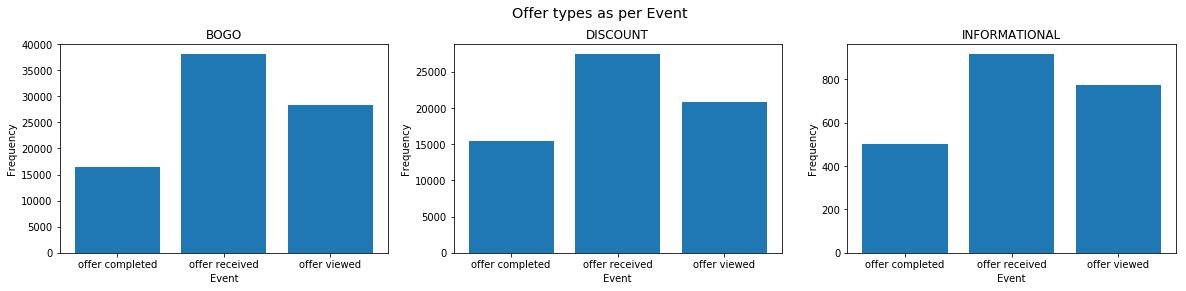

In [96]:
#Bar plots for offer types as per event
fig, ax = plt.subplots(1, 3, sharex=True, figsize=(20,4))
plt.sca(ax[0])
plt.bar(x=pd.value_counts(result['event'][result['gender'] == 'M']).index, height=pd.value_counts(result['event'][result['gender'] == 'M']))
plt.xlabel('Event')
plt.ylabel('Frequency')
plt.title('BOGO')
plt.sca(ax[1])
plt.bar(x=pd.value_counts(result['event'][result['gender'] == 'F']).index, height=pd.value_counts(result['event'][result['gender'] == 'F']))
plt.xlabel('Event')
plt.ylabel('Frequency')
plt.title('DISCOUNT')
plt.sca(ax[2])
plt.bar(x=pd.value_counts(result['event'][result['gender'] == 'O']).index, height=pd.value_counts(result['event'][result['gender'] == 'O']))
plt.xlabel('Event')
plt.ylabel('Frequency')
plt.title('INFORMATIONAL')
fig.suptitle('Offer types as per Event', fontsize='x-large')
fig.subplots_adjust(top=0.85)

As per the above bar plots, Bogo, Discount and Informational portfolios have the highest number of offers received followed by offer viewed and the lowest of completed offers.

In [97]:
event_type = pd.get_dummies(result['event'])
result = pd.concat([result, event_type], axis=1, sort=False)
result = result.drop(columns = ['event'])
result

,difficulty,duration,offer_id_t,reward,web,email,mobile,social,bogo,discount,...,time,age,gender,income,membership_year,membership_month,membership_day,offer completed,offer received,offer viewed
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,0,1,1,1,1,0,...,0,64.0,M,100000.0,2017,9,Saturday,0,1,0
1,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,0,1,1,1,1,0,...,102,64.0,M,100000.0,2017,9,Saturday,0,0,1
2,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,0,1,1,1,1,0,...,504,64.0,M,100000.0,2017,9,Saturday,0,1,0
3,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,0,1,1,1,1,0,...,510,64.0,M,100000.0,2017,9,Saturday,0,0,1
4,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,0,1,1,1,1,0,...,510,64.0,M,100000.0,2017,9,Saturday,1,0,0
5,0,4,3f207df678b143eea3cee63160fa8bed,0,1,1,1,0,0,0,...,408,64.0,M,100000.0,2017,9,Saturday,0,1,0
6,0,4,3f207df678b143eea3cee63160fa8bed,0,1,1,1,0,0,0,...,468,64.0,M,100000.0,2017,9,Saturday,0,0,1
7,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,1,1,0,0,0,1,...,168,64.0,M,100000.0,2017,9,Saturday,0,1,0
8,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,1,1,0,0,0,1,...,174,64.0,M,100000.0,2017,9,Saturday,0,0,1
9,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,1,1,0,0,0,1,...,180,64.0,M,100000.0,2017,9,Saturday,1,0,0


In [98]:
a = np.array([1, 0, 0])
b = np.array([0, 0, 0])
c = np.array([0, 0, 1])
if (a+b+c).all() == True:
    print('TRUE')
else:
    print('FALSE')
(a+b+c).all()

FALSE


False

In [99]:
len(result['mem_id_t'][result['bogo'] == 1].unique())

13082

In [100]:
trans_comp = []
mem_ids = result['mem_id_t'][result['bogo'] == 1].unique()#['4b0da7e80e5945209a1fdddfe813dbe0']#result['mem_id_t'].unique()
for mem in mem_ids:
    offer_ids = result['offer_id_t'][result['mem_id_t'] == str(mem)][result['bogo']==1].unique()
    #print(offer_ids)
    for offer in offer_ids:
        ov = np.array(result['offer viewed'][result['mem_id_t'] == str(mem)][result['offer_id_t'] == str(offer)][result['bogo']==1])
        oR = np.array(result['offer received'][result['mem_id_t'] == str(mem)][result['offer_id_t'] == str(offer)][result['bogo']==1])
        oc = np.array(result['offer completed'][result['mem_id_t'] == str(mem)][result['offer_id_t'] == str(offer)][result['bogo']==1])
        
        #print(ov)
        #print(oR)
        #print(oc)
        if not np.any(ov) or not np.any(oR) or not np.any(oc):
            trans_comp.append('Not Completed')
        else:
            trans_comp.append('Completed')

In [101]:
bogo = result[result['bogo'] == 1]
print(len(bogo.drop_duplicates(subset = ['mem_id_t','offer_id_t'])))
print(len(trans_comp))

22062
22062


In [102]:
trans_comp_d = []
mem_ids = result['mem_id_t'][result['discount'] == 1].unique()#['4b0da7e80e5945209a1fdddfe813dbe0']#result['mem_id_t'].unique()
for mem in mem_ids:
    offer_ids = result['offer_id_t'][result['mem_id_t'] == str(mem)][result['discount']==1].unique()
    #print(offer_ids)
    for offer in offer_ids:
        ov = np.array(result['offer viewed'][result['mem_id_t'] == str(mem)][result['offer_id_t'] == str(offer)][result['discount']==1])
        oR = np.array(result['offer received'][result['mem_id_t'] == str(mem)][result['offer_id_t'] == str(offer)][result['discount']==1])
        oc = np.array(result['offer completed'][result['mem_id_t'] == str(mem)][result['offer_id_t'] == str(offer)][result['discount']==1])
        
        #print(ov)
        #print(oR)
        #print(oc)
        if not np.any(ov) or not np.any(oR) or not np.any(oc):
            trans_comp_d.append('Not Completed')
        else:
            trans_comp_d.append('Completed')

In [103]:
discount = result[result['discount'] == 1]
print(len(discount.drop_duplicates(subset = ['mem_id_t','offer_id_t'])))
print(len(trans_comp_d))

22119
22119


For bogo and discount portfolio types, all three events offered viewed, offer received and offer completed need to be accomplished to consider the transaction to be completed. Failure in doing so will result in an incomplete transaction.

In [104]:
trans_comp_i = []
mem_ids = result['mem_id_t'][result['informational'] == 1].unique()#['4b0da7e80e5945209a1fdddfe813dbe0']#result['mem_id_t'].unique()
for mem in mem_ids:
    offer_ids = result['offer_id_t'][result['mem_id_t'] == str(mem)][result['informational']==1].unique()
    #print(offer_ids)
    for offer in offer_ids:
        oR = np.array(result['offer received'][result['mem_id_t'] == str(mem)][result['offer_id_t'] == str(offer)][result['informational']==1])
        oc = np.array(result['offer completed'][result['mem_id_t'] == str(mem)][result['offer_id_t'] == str(offer)][result['informational']==1])
        
        #print(oR)
        #print(oc)
        if not np.any(oR) or not np.any(oc):
            trans_comp_i.append('Not Completed')
        else:
            trans_comp_i.append('Completed')

In [105]:
informational = result[result['informational'] == 1]
print(len(informational.drop_duplicates(subset = ['mem_id_t','offer_id_t'])))
print(len(trans_comp_i))

11041
11041


For informational portfolio type, only offer received and offer completed need to be accomplished in order for the transaction to be completed. Failure in doing so will result in an incomplete transaction.

In [107]:
bogo = bogo.drop_duplicates(subset = ['mem_id_t','offer_id_t'])
discount = discount.drop_duplicates(subset = ['mem_id_t','offer_id_t'])
informational = informational.drop_duplicates(subset = ['mem_id_t','offer_id_t'])
bogo['transaction']=trans_comp
discount['transaction']=trans_comp_d
informational['transaction']=trans_comp_i
bogo.to_csv(r'./bogo_csv.csv', index = False)
discount.to_csv(r'./discount_csv.csv', index = False)
informational.to_csv(r'./informational_csv.csv', index = False)